In [1]:
import glob, os, cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
modelName = "256_64_16_6_0.0001_20"
fitted = glob.glob("fitted/{0}/*.jpg".format(modelName))
fittedCsv = pd.read_csv("fitted.csv")
truthCsv = pd.read_csv("train.csv")
flattenList = lambda l: [item for sublist in l for item in sublist]

In [3]:
croppedFolder = "cropped/{0}/".format(modelName)
if not os.path.exists(croppedFolder):
    os.mkdir(croppedFolder)

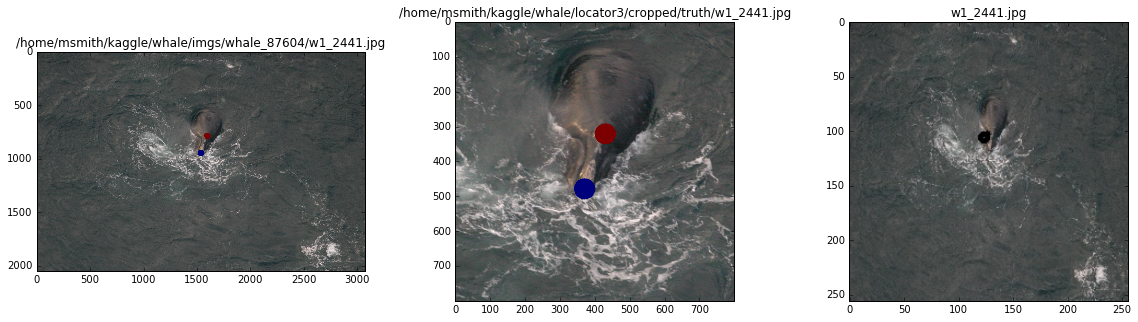

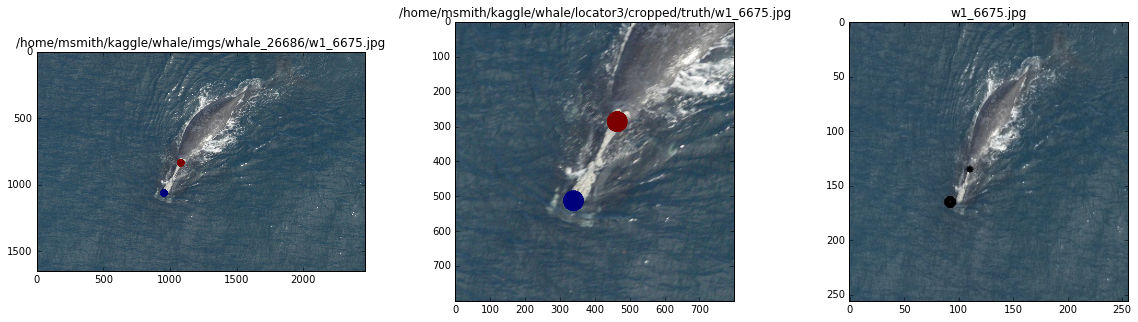

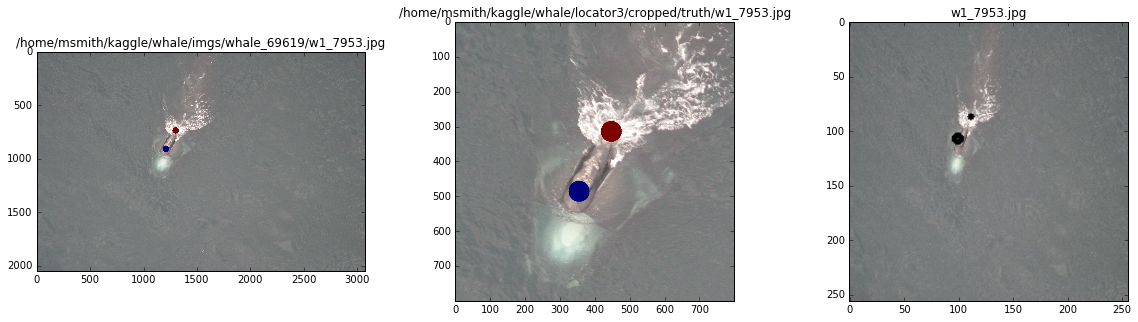

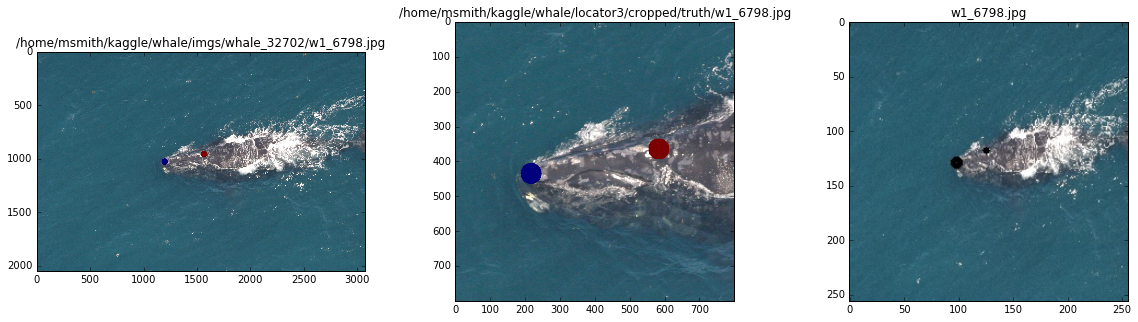

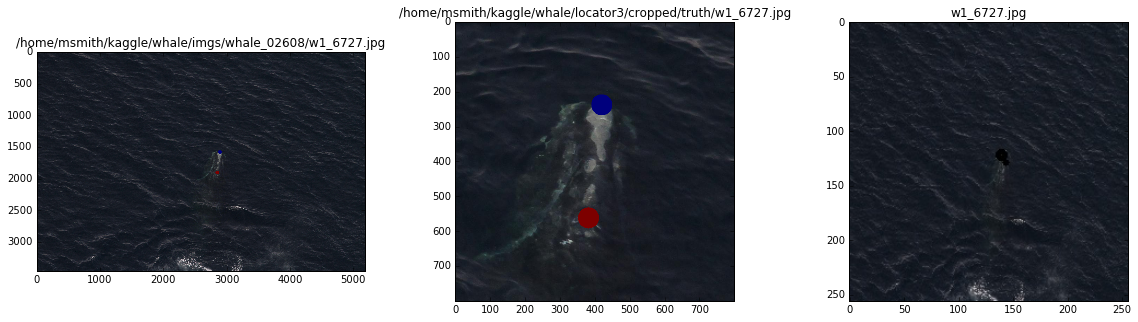

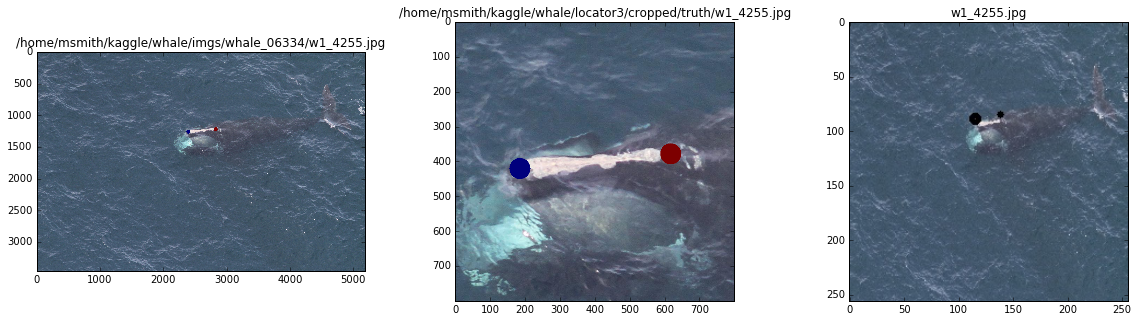

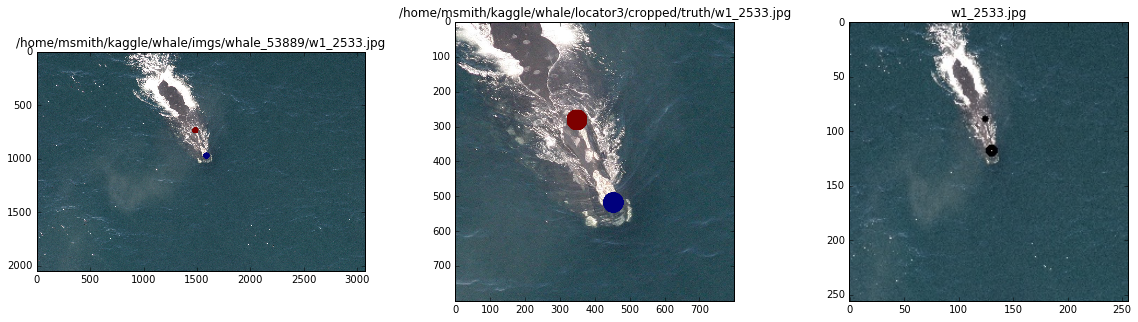

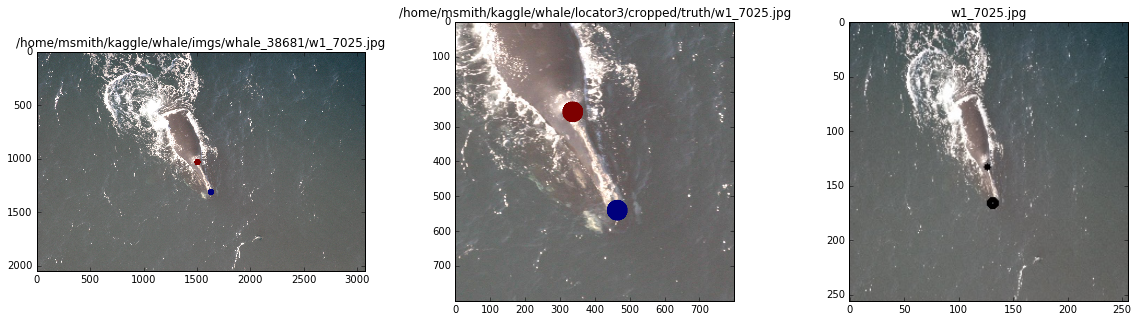

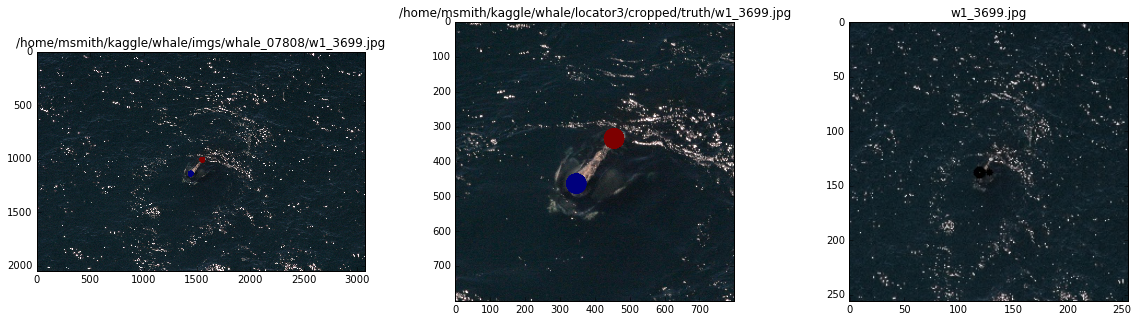

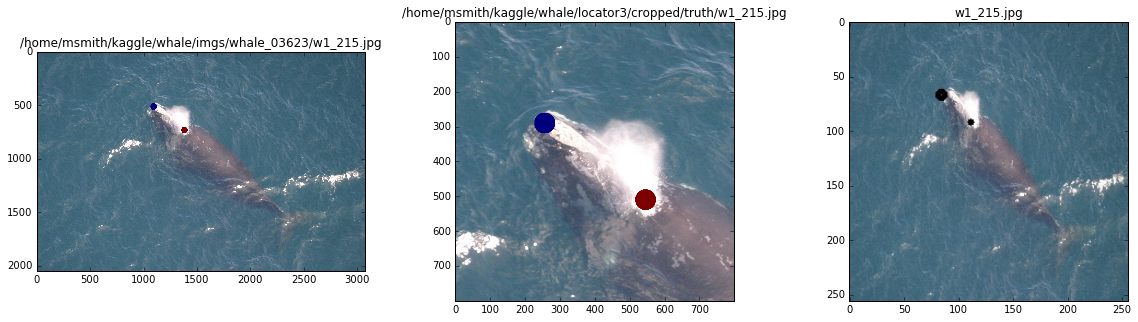

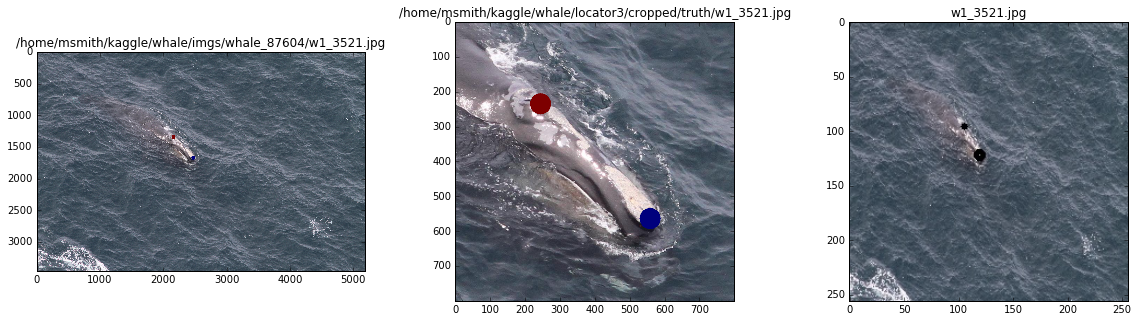

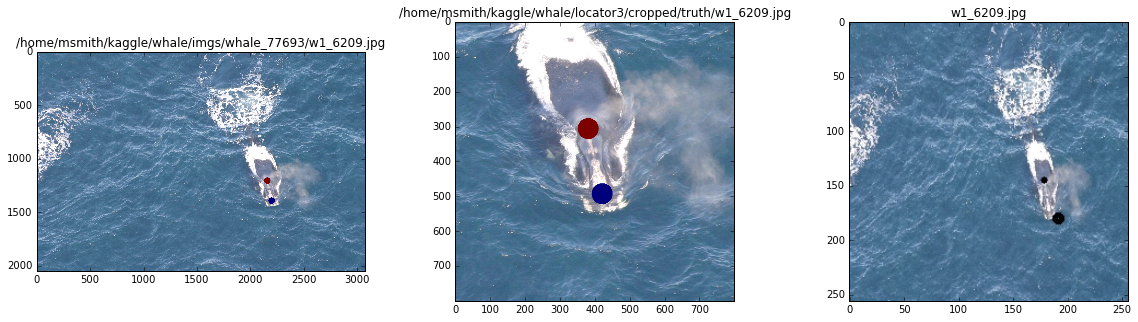

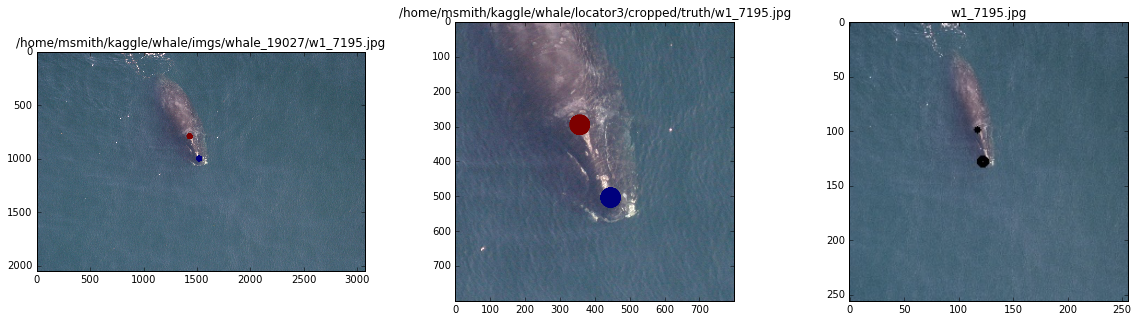

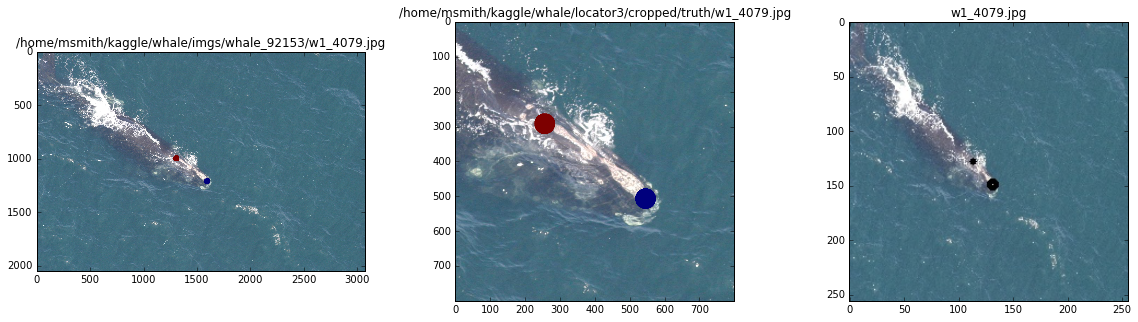

In [31]:
df = []
pad = 400
error = 0
truth = 1
if truth == 1:   
    csv = truthCsv
    savePath = "cropped/truth/"
else:
    csv = fittedCsv
    savePath = croppedFolder
    
for f in fitted:
    img = cv2.imread(f)
    name = f.split("/")[-1]
    origPath = glob.glob("../imgs/*/{0}".format(name))[0]
    origPath = os.path.abspath(origPath)
    imgO = cv2.imread(origPath)
    h,w,c = imgO.shape  
    def rowToCoords(csv,path,imgShape,rescale=0):
        h,w,c = imgShape  
        csvRow = csv[csv["path"] == path]
        x1 = csvRow.x1
        y1 = csvRow.y1
        x2 = csvRow.x2
        y2 = csvRow.y2
        xM = (x2 + x1)/2.0
        yM = (y2 + y1)/2.0
        if rescale == 1:
            x1*=w
            x2*=w
            y1*=h
            y2*=h
            xM*=w
            yM*=h

        return [int(i.values[0]) for i in x1, y1, x2, y2, xM, yM]

    x1R, y1R, x2R, y2R, xMR, yMR = rowToCoords(csv,origPath,imgO.shape,rescale=1)  
    imgC = imgO[yMR-pad:yMR+pad,xMR-pad:xMR+pad].copy()
    xCorner, yCorner = xMR-pad, yMR-pad # top left corner of cropped area

    
    x1New, y1New = x1R - xCorner, y1R - yCorner
    x2New, y2New = x2R - xCorner, y2R - yCorner
    if np.any(np.array(imgC.shape)==0):
        error += 1
        continue
    wp = os.path.abspath(savePath + name)
    cv2.imwrite(wp,imgC)
    
    # New (normalized) coords
    h,w,c = imgC.shape
    df.append([wp,float(x1New)/w, float(y1New)/h, float(x2New)/w, float(y2New)/h,w,h])
    
    def show():

        cv2.circle(imgO,(x1R,y1R),30,(125,0,0),-1)
        cv2.circle(imgO,(x2R,y2R),30,(0,0,125),-1)

        cv2.circle(imgC,(x1New,y1New),30,(125,0,0),-1)
        cv2.circle(imgC,(x2New,y2New),30,(0,0,125),-1)

        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.imshow(imgO[:,:,::-1]); plt.title(origPath);
        plt.subplot(132)
        plt.imshow(imgC[:,:,::-1]); plt.title(wp);
        plt.subplot(133)
        plt.imshow(img[:,:,::-1]);plt.title(name);
        plt.show()
    if np.random.uniform() < 0.003:
        show()
        
dfC = pd.DataFrame(df)
dfC.columns = ["path","x1","y1","x2","y2","w","h"]
dfC.to_csv(savePath+"train.csv",index=0)